# UK Cyber Fraud Assistant - Fine-Tuning with Mistral-7B (Updated)

In [1]:
# Install Unsloth and dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers
!pip install unsloth trl peft accelerate bitsandbytes

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.8/184.8 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
# Verify GPU setup
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Available VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

CUDA available: True
GPU: NVIDIA L4
CUDA version: 12.6
Available VRAM: 22.2 GB


## Load and Prepare Dataset

In [3]:
from google.colab import drive
import json
from datasets import Dataset
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Dissertation/retrain/model_training/111_master_fraud_qa_dataset.json'

# Load the fraud Q&A dataset
with open(dataset_path, 'r') as f:
    fraud_data = json.load(f)

print(f"Total samples: {len(fraud_data)}")
print(f"Sample keys: {list(fraud_data[0].keys())}")

# Preview a sample
sample = fraud_data[0]
print(f"\nSample instruction: {sample['instruction']}")
print(f"\nSample output (first 200 chars): {sample['output'][:200]}...")

Mounted at /content/drive
Total samples: 111
Sample keys: ['instruction', 'input', 'output', 'system', 'source_document', 'source_url', 'data_source', 'generated_by']

Sample instruction: I think I've been scammed after paying for a loan arrangement fee upfront. What should I do?

Sample output (first 200 chars): It sounds like you may have been a victim of loan fee fraud, which is a type of advance fee fraud. It's understandable to feel concerned, but there are steps you can take. First, you should know that ...


In [4]:
# Format data for instruction tuning with Mistral chat template
def format_fraud_prompt(sample):
    system_message = "You are a helpful UK cyber fraud assistant providing empathetic support to fraud victims. Provide accurate, UK-specific guidance with proper contact numbers and procedures."

    # Mistral chat format
    formatted_text = f"<s>[INST] {system_message}\n\n{sample['instruction']} [/INST] {sample['output']}</s>"

    return formatted_text

# Apply formatting
formatted_data = [format_fraud_prompt(item) for item in fraud_data]

# Create train/validation split (80/20)
split_idx = int(len(formatted_data) * 0.8)
train_data = formatted_data[:split_idx]
val_data = formatted_data[split_idx:]

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Create datasets
train_dataset = Dataset.from_dict({"text": train_data})
val_dataset = Dataset.from_dict({"text": val_data})

# Preview formatted sample
print(f"\nFormatted sample (first 300 chars):\n{formatted_data[0][:300]}...")

Training samples: 88
Validation samples: 23

Formatted sample (first 300 chars):
<s>[INST] You are a helpful UK cyber fraud assistant providing empathetic support to fraud victims. Provide accurate, UK-specific guidance with proper contact numbers and procedures.

I think I've been scammed after paying for a loan arrangement fee upfront. What should I do? [/INST] It sounds like ...


## Load Model and Configure LoRA

In [5]:
from unsloth import FastLanguageModel
import torch

# Full precision Mistral model
model_name = "mistralai/Mistral-7B-Instruct-v0.3"  # Original unquantized model
max_seq_length = 2048
dtype = torch.bfloat16  # Full precision

# Load model without quantization
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=False,  # No quantization
    device_map={"": 0},
)

print("Model loaded in full precision for LoRA training")
print(f"Model device: {next(model.parameters()).device}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.9: Fast Mistral patching. Transformers: 4.55.2.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Model loaded in full precision for LoRA training
Model device: cuda:0


In [6]:
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.max_memory_allocated()/1024**3:.2f}GB")

print_gpu_memory()

GPU Memory: 13.52GB / 13.52GB


In [7]:
# Configure LoRA for optimal fraud assistant training
model = FastLanguageModel.get_peft_model(
    model,
    r=64,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_alpha=128,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

print("LoRA configuration applied")
model.print_trainable_parameters()

Unsloth 2025.8.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


LoRA configuration applied
trainable params: 167,772,160 || all params: 7,415,795,712 || trainable%: 2.2624


In [8]:
print_gpu_memory()

GPU Memory: 14.14GB / 14.15GB


## Configure Training Parameters

In [9]:
from trl import SFTTrainer
from transformers import TrainingArguments, EarlyStoppingCallback

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=10,
    num_train_epochs=5,
    learning_rate=1e-4,
    bf16=torch.cuda.is_bf16_supported(),
    fp16=not torch.cuda.is_bf16_supported(),
    logging_steps=5,
    optim="adamw_torch",                # Full precision optimizer
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    seed=3407,
    output_dir="/content/drive/MyDrive/Dissertation/retrain/trained_models",
    save_strategy="epoch",
    save_total_limit=2,
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_pin_memory=True,
    remove_unused_columns=False,
    report_to="none",
)

print("Training arguments configured")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Total training steps: {len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")

Training arguments configured
Effective batch size: 16
Total training steps: 25


In [10]:
# Import required libraries for metrics tracking
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import json
import pandas as pd
from transformers import TrainerCallback

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Initialize tracking dictionaries
training_metrics = {
    'epoch': [],
    'step': [],
    'train_loss': [],
    'eval_loss': [],
    'learning_rate': [],
    'train_runtime': [],
    'train_samples_per_second': [],
    'eval_runtime': [],
    'eval_samples_per_second': []
}

# Custom callback to track training metrics
class MetricsTrackingCallback(TrainerCallback):
    def __init__(self, metrics_dict):
        self.metrics = metrics_dict

    def on_log(self, args, state, control, model=None, logs=None, **kwargs):
        if logs is not None:
            # Track training metrics
            if 'loss' in logs:
                self.metrics['train_loss'].append(logs['loss'])
                self.metrics['step'].append(state.global_step)

            if 'learning_rate' in logs:
                self.metrics['learning_rate'].append(logs['learning_rate'])

            # Track evaluation metrics
            if 'eval_loss' in logs:
                self.metrics['eval_loss'].append(logs['eval_loss'])

            if 'eval_runtime' in logs:
                self.metrics['eval_runtime'].append(logs['eval_runtime'])

            if 'eval_samples_per_second' in logs:
                self.metrics['eval_samples_per_second'].append(logs['eval_samples_per_second'])

    def on_epoch_end(self, args, state, control, model=None, logs=None, **kwargs):
        self.metrics['epoch'].append(state.epoch)

# Create the metrics callback
metrics_callback = MetricsTrackingCallback(training_metrics)

print("Visualization libraries loaded and metrics tracking initialized")

# Move all model parameters to GPU before creating trainer
model = model.to("cuda")

# Verify all parameters are on GPU
print("Checking model device placement...")
for name, param in model.named_parameters():
    if param.device.type == 'meta':
        print(f"Warning: {name} still on meta device")
    elif param.device.type != 'cuda':
        print(f"Moving {name} from {param.device} to cuda")
        param.data = param.data.to("cuda")

print("All parameters moved to GPU")

# Initialize trainer with early stopping and metrics tracking
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    args=training_args,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.01),  # Stop if no improvement for 1 epochs
        metrics_callback  # Track training metrics
    ]
)

print("Trainer initialized successfully with early stopping and metrics tracking!")

Visualization libraries loaded and metrics tracking initialized
Checking model device placement...
All parameters moved to GPU


Unsloth: Tokenizing ["text"]:   0%|          | 0/88 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/23 [00:00<?, ? examples/s]

Trainer initialized successfully with early stopping and metrics tracking!


## Start Training

In [11]:
# Start training
print("Starting training...")
trainer_stats = trainer.train()

print("Training completed!")
print(f"Final training loss: {trainer_stats.training_loss:.4f}")
print(f"Training time: {trainer_stats.metrics['train_runtime']:.1f} seconds")

Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 88 | Num Epochs = 5 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 167,772,160 of 7,415,795,712 (2.26% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Epoch,Training Loss,Validation Loss
1,2.290600,1.470100
2,1.296800,1.120770
3,0.846000,1.062971
4,0.511300,1.240112


Unsloth: Not an error, but MistralForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Training completed!
Final training loss: 1.0831
Training time: 163.0 seconds


## Training Results Analysis and Visualization

In [12]:
# Compile and display training metrics summary
training_summary = {
    'Model': model_name,
    'Dataset Size': len(fraud_data),
    'Training Samples': len(train_data),
    'Validation Samples': len(val_data),
    'Max Sequence Length': max_seq_length,
    'LoRA Rank': 64,
    'LoRA Alpha': 128,
    'Learning Rate': training_args.learning_rate,
    'Batch Size': training_args.per_device_train_batch_size,
    'Gradient Accumulation Steps': training_args.gradient_accumulation_steps,
    'Effective Batch Size': training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps,
    'Number of Epochs': training_args.num_train_epochs,
    'Final Training Loss': trainer_stats.training_loss,
    'Training Runtime (seconds)': trainer_stats.metrics['train_runtime'],
    'Training Samples per Second': trainer_stats.metrics.get('train_samples_per_second', 'N/A'),
    'Total Training Steps': len(training_metrics['train_loss']),
}

# Display summary
print("=== TRAINING SUMMARY ===")
for key, value in training_summary.items():
    print(f"{key}: {value}")

# Save training summary to JSON
summary_path = "/content/drive/MyDrive/Dissertation/retrain/trained_models/training_summary.json"
with open(summary_path, 'w') as f:
    json.dump(training_summary, f, indent=2, default=str)

print(f"\nTraining summary saved to: {summary_path}")

=== TRAINING SUMMARY ===
Model: mistralai/Mistral-7B-Instruct-v0.3
Dataset Size: 111
Training Samples: 88
Validation Samples: 23
Max Sequence Length: 2048
LoRA Rank: 64
LoRA Alpha: 128
Learning Rate: 0.0001
Batch Size: 2
Gradient Accumulation Steps: 8
Effective Batch Size: 16
Number of Epochs: 5
Final Training Loss: 1.0830872108538945
Training Runtime (seconds): 162.9652
Training Samples per Second: 2.7
Total Training Steps: 4

Training summary saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/training_summary.json


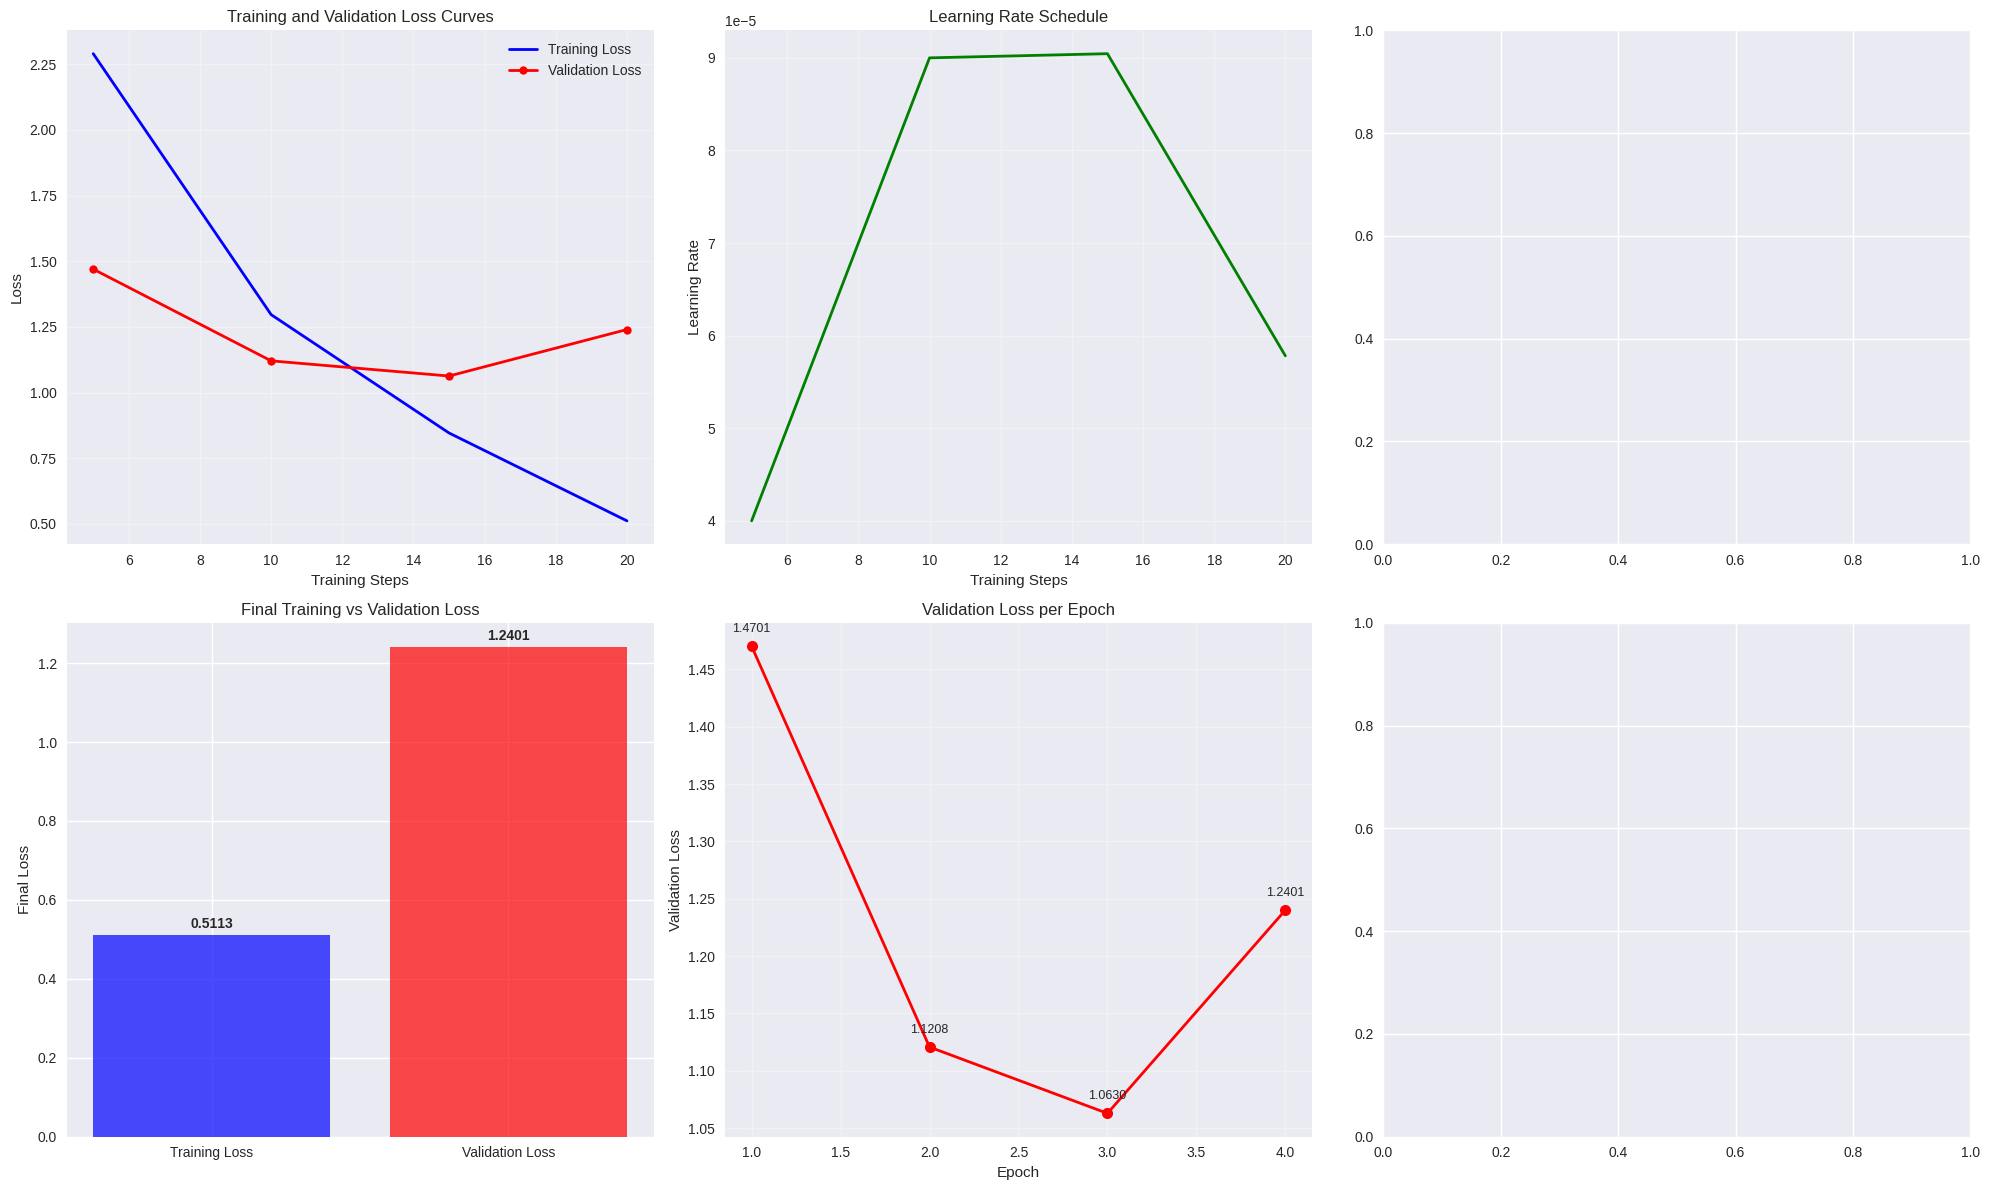

Training visualization saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/training_visualization.png


In [13]:
# Create comprehensive training visualization
plt.figure(figsize=(20, 12))

# 1. Training and Validation Loss
plt.subplot(2, 3, 1)
if training_metrics['train_loss']:
    plt.plot(training_metrics['step'], training_metrics['train_loss'], 'b-', label='Training Loss', linewidth=2)

# Plot validation loss at epoch intervals
if training_metrics['eval_loss']:
    # Calculate approximate steps for eval points
    total_steps = max(training_metrics['step']) if training_metrics['step'] else 1
    eval_steps = [int(i * total_steps / len(training_metrics['eval_loss'])) for i in range(1, len(training_metrics['eval_loss']) + 1)]
    plt.plot(eval_steps, training_metrics['eval_loss'], 'r-o', label='Validation Loss', linewidth=2, markersize=6)

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Learning Rate Schedule
plt.subplot(2, 3, 2)
if training_metrics['learning_rate']:
    plt.plot(training_metrics['step'][:len(training_metrics['learning_rate'])],
             training_metrics['learning_rate'], 'g-', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# 3. Training Loss Smoothed (Moving Average)
plt.subplot(2, 3, 3)
if len(training_metrics['train_loss']) > 10:
    window_size = max(5, len(training_metrics['train_loss']) // 20)
    smoothed_loss = pd.Series(training_metrics['train_loss']).rolling(window=window_size).mean()
    plt.plot(training_metrics['step'], training_metrics['train_loss'], 'b-', alpha=0.3, label='Raw Training Loss')
    plt.plot(training_metrics['step'], smoothed_loss, 'b-', linewidth=2, label=f'Smoothed (window={window_size})')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss (Smoothed)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 4. Loss Comparison Bar Chart
plt.subplot(2, 3, 4)
if training_metrics['train_loss'] and training_metrics['eval_loss']:
    final_train_loss = training_metrics['train_loss'][-1]
    final_val_loss = training_metrics['eval_loss'][-1]

    bars = plt.bar(['Training Loss', 'Validation Loss'], [final_train_loss, final_val_loss],
                   color=['blue', 'red'], alpha=0.7)
    plt.ylabel('Final Loss')
    plt.title('Final Training vs Validation Loss')

    # Add value labels on bars
    for bar, value in zip(bars, [final_train_loss, final_val_loss]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 5. Training Progress Over Epochs
plt.subplot(2, 3, 5)
if training_metrics['eval_loss']:
    epochs = list(range(1, len(training_metrics['eval_loss']) + 1))
    plt.plot(epochs, training_metrics['eval_loss'], 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss per Epoch')
    plt.grid(True, alpha=0.3)

    # Annotate each point
    for i, (epoch, loss) in enumerate(zip(epochs, training_metrics['eval_loss'])):
        plt.annotate(f'{loss:.4f}', (epoch, loss), textcoords="offset points",
                    xytext=(0,10), ha='center', fontsize=9)

# 6. Loss Improvement Rate
plt.subplot(2, 3, 6)
if len(training_metrics['train_loss']) > 1:
    loss_improvements = []
    window = 50  # Calculate improvement over last 50 steps
    for i in range(window, len(training_metrics['train_loss'])):
        old_loss = np.mean(training_metrics['train_loss'][i-window:i-window+10])
        new_loss = np.mean(training_metrics['train_loss'][i-10:i])
        improvement = old_loss - new_loss
        loss_improvements.append(improvement)

    if loss_improvements:
        plt.plot(range(window, len(training_metrics['train_loss'])), loss_improvements, 'purple', linewidth=2)
        plt.xlabel('Training Steps')
        plt.ylabel('Loss Improvement')
        plt.title(f'Loss Improvement Rate (over {window} steps)')
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/retrain/trained_models/training_visualization.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("Training visualization saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/training_visualization.png")

In [14]:
# Create detailed metrics table for dissertation
metrics_df = pd.DataFrame({
    'Epoch': list(range(1, len(training_metrics['eval_loss']) + 1)) if training_metrics['eval_loss'] else [],
    'Validation_Loss': training_metrics['eval_loss'],
    'Training_Loss_Final_in_Epoch': [training_metrics['train_loss'][i] for i in
                                   range(len(training_metrics['train_loss']) // len(training_metrics['eval_loss']) - 1,
                                         len(training_metrics['train_loss']),
                                         len(training_metrics['train_loss']) // len(training_metrics['eval_loss']))]
                                   if training_metrics['eval_loss'] and training_metrics['train_loss'] else []
})

print("=== EPOCH-BY-EPOCH TRAINING METRICS ===")
if not metrics_df.empty:
    print(metrics_df.round(6))

    # Calculate improvements
    print("\n=== LOSS IMPROVEMENTS ===")
    if len(metrics_df) > 1:
        val_improvement = metrics_df['Validation_Loss'].iloc[0] - metrics_df['Validation_Loss'].iloc[-1]
        val_improvement_pct = (val_improvement / metrics_df['Validation_Loss'].iloc[0]) * 100

        print(f"Initial Validation Loss: {metrics_df['Validation_Loss'].iloc[0]:.6f}")
        print(f"Final Validation Loss: {metrics_df['Validation_Loss'].iloc[-1]:.6f}")
        print(f"Validation Loss Improvement: {val_improvement:.6f} ({val_improvement_pct:.2f}%)")

        if 'Training_Loss_Final_in_Epoch' in metrics_df.columns and len(metrics_df['Training_Loss_Final_in_Epoch']) > 1:
            train_improvement = metrics_df['Training_Loss_Final_in_Epoch'].iloc[0] - metrics_df['Training_Loss_Final_in_Epoch'].iloc[-1]
            train_improvement_pct = (train_improvement / metrics_df['Training_Loss_Final_in_Epoch'].iloc[0]) * 100
            print(f"Training Loss Improvement: {train_improvement:.6f} ({train_improvement_pct:.2f}%)")

# Save detailed metrics
metrics_path = "/content/drive/MyDrive/Dissertation/retrain/trained_models/detailed_metrics.csv"
if not metrics_df.empty:
    metrics_df.to_csv(metrics_path, index=False)
    print(f"\nDetailed metrics saved to: {metrics_path}")

# Save raw training metrics for further analysis
raw_metrics_path = "/content/drive/MyDrive/Dissertation/retrain/trained_models/raw_training_metrics.json"
with open(raw_metrics_path, 'w') as f:
    json.dump(training_metrics, f, indent=2)
print(f"Raw training metrics saved to: {raw_metrics_path}")

=== EPOCH-BY-EPOCH TRAINING METRICS ===
   Epoch  Validation_Loss  Training_Loss_Final_in_Epoch
0      1         1.470100                        2.2906
1      2         1.120770                        1.2968
2      3         1.062971                        0.8460
3      4         1.240112                        0.5113

=== LOSS IMPROVEMENTS ===
Initial Validation Loss: 1.470100
Final Validation Loss: 1.240112
Validation Loss Improvement: 0.229987 (15.64%)
Training Loss Improvement: 1.779300 (77.68%)

Detailed metrics saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/detailed_metrics.csv
Raw training metrics saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/raw_training_metrics.json


/tmp/ipython-input-3545265803.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


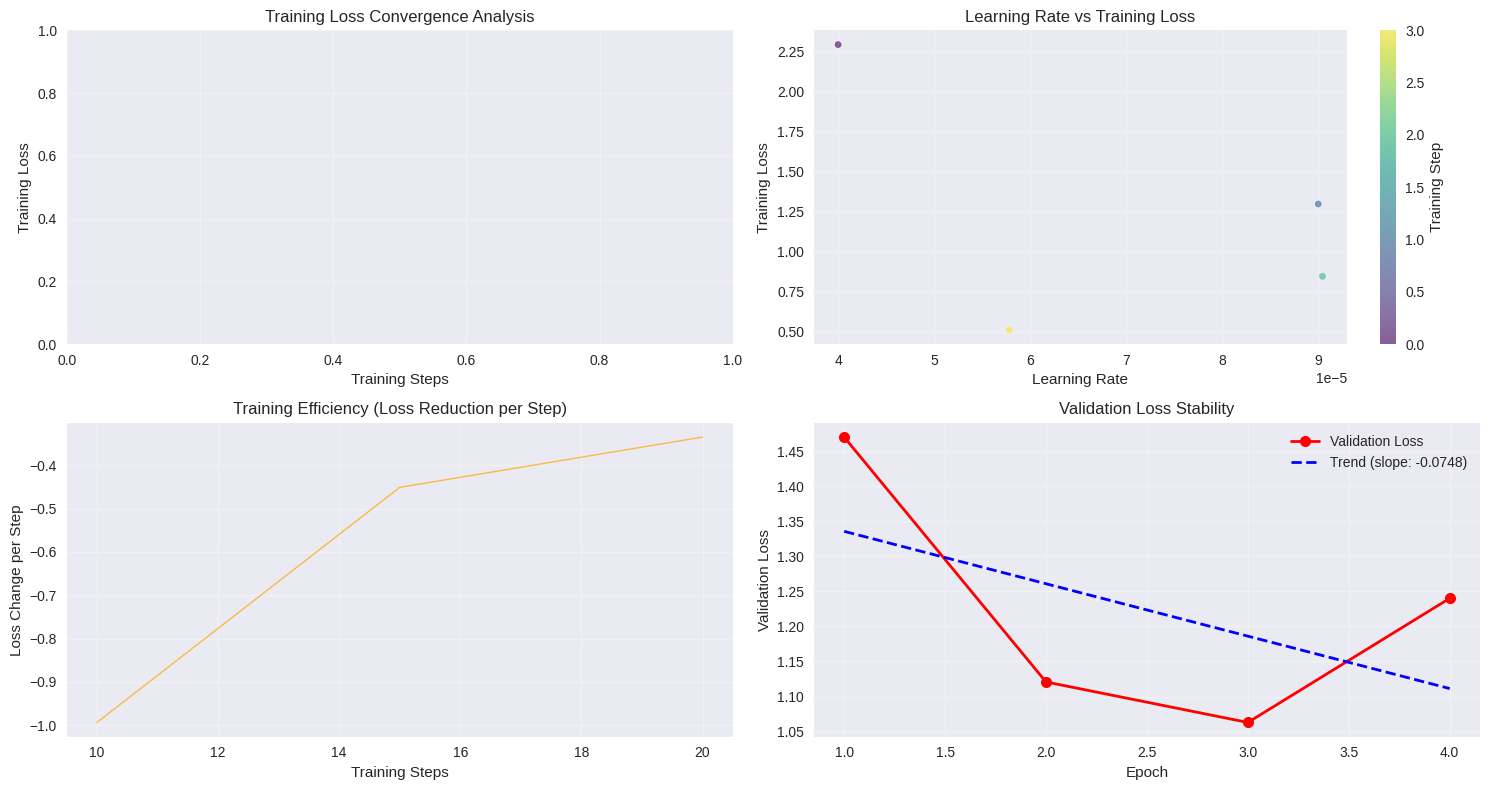

Convergence analysis saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/convergence_analysis.png


In [15]:
# Convergence Analysis and Training Efficiency
plt.figure(figsize=(15, 8))

# 1. Loss Convergence Analysis
plt.subplot(2, 2, 1)
if training_metrics['train_loss']:
    # Calculate moving average convergence
    window_sizes = [10, 25, 50]
    colors = ['blue', 'green', 'red']

    for window, color in zip(window_sizes, colors):
        if len(training_metrics['train_loss']) > window:
            moving_avg = pd.Series(training_metrics['train_loss']).rolling(window=window).mean()
            plt.plot(training_metrics['step'], moving_avg, color=color,
                    label=f'Moving Avg (window={window})', linewidth=2)

    plt.xlabel('Training Steps')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Convergence Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 2. Learning Rate vs Loss Correlation
plt.subplot(2, 2, 2)
if training_metrics['learning_rate'] and training_metrics['train_loss']:
    min_len = min(len(training_metrics['learning_rate']), len(training_metrics['train_loss']))
    if min_len > 1:
        plt.scatter(training_metrics['learning_rate'][:min_len],
                   training_metrics['train_loss'][:min_len],
                   alpha=0.6, s=20, c=range(min_len), cmap='viridis')
        plt.xlabel('Learning Rate')
        plt.ylabel('Training Loss')
        plt.title('Learning Rate vs Training Loss')
        plt.colorbar(label='Training Step')
        plt.grid(True, alpha=0.3)

# 3. Training Efficiency (Loss per Step)
plt.subplot(2, 2, 3)
if len(training_metrics['train_loss']) > 1:
    loss_per_step = np.diff(training_metrics['train_loss'])
    steps = training_metrics['step'][1:len(loss_per_step)+1]
    plt.plot(steps, loss_per_step, 'orange', alpha=0.7, linewidth=1)

    # Add smoothed version
    if len(loss_per_step) > 10:
        smoothed = pd.Series(loss_per_step).rolling(window=10).mean()
        plt.plot(steps, smoothed, 'red', linewidth=2, label='Smoothed')
        plt.legend()

    plt.xlabel('Training Steps')
    plt.ylabel('Loss Change per Step')
    plt.title('Training Efficiency (Loss Reduction per Step)')
    plt.grid(True, alpha=0.3)

# 4. Validation Loss Stability
plt.subplot(2, 2, 4)
if len(training_metrics['eval_loss']) > 1:
    epochs = list(range(1, len(training_metrics['eval_loss']) + 1))
    val_losses = training_metrics['eval_loss']

    plt.plot(epochs, val_losses, 'ro-', linewidth=2, markersize=8, label='Validation Loss')

    # Calculate and show trend
    if len(val_losses) > 2:
        z = np.polyfit(epochs, val_losses, 1)
        p = np.poly1d(z)
        plt.plot(epochs, p(epochs), 'b--', linewidth=2, label=f'Trend (slope: {z[0]:.4f})')

    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Stability')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/retrain/trained_models/convergence_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("Convergence analysis saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/convergence_analysis.png")

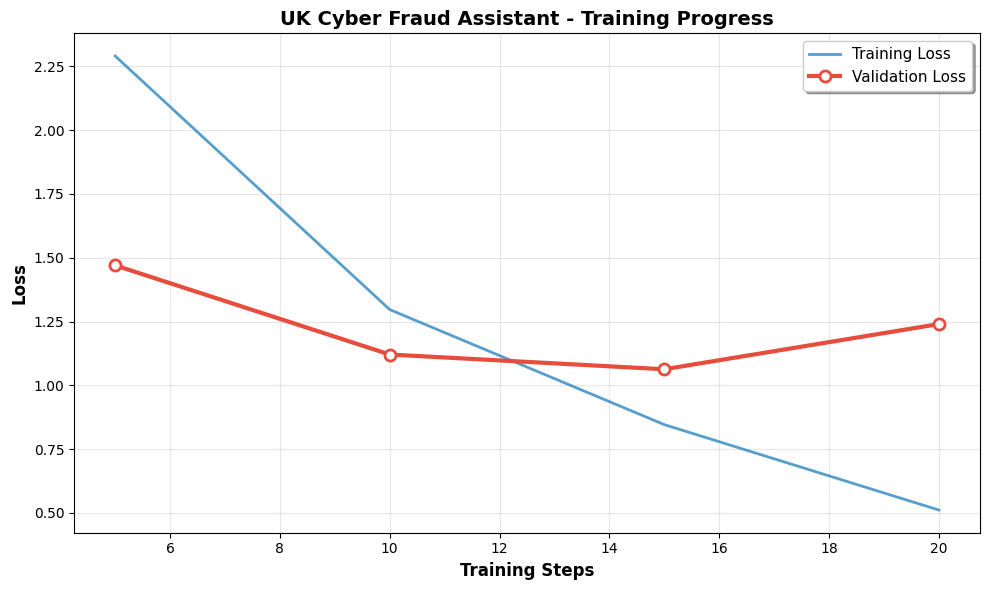

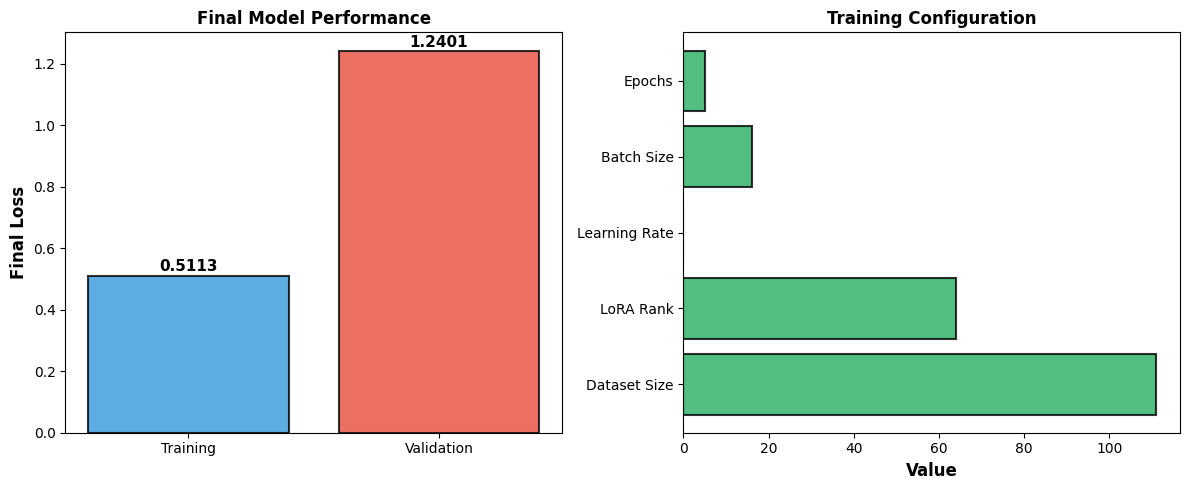

Publication-ready plots saved for dissertation use!


In [16]:
# Create publication-ready plots for dissertation
plt.style.use('default')  # Use clean default style for publications

# Plot 1: Training and Validation Loss (Clean)
plt.figure(figsize=(10, 6))
if training_metrics['train_loss'] and training_metrics['eval_loss']:
    # Plot training loss
    plt.plot(training_metrics['step'], training_metrics['train_loss'],
             color='#2E86C1', linewidth=2, label='Training Loss', alpha=0.8)

    # Plot validation loss
    total_steps = max(training_metrics['step'])
    eval_steps = [int(i * total_steps / len(training_metrics['eval_loss']))
                 for i in range(1, len(training_metrics['eval_loss']) + 1)]
    plt.plot(eval_steps, training_metrics['eval_loss'],
             color='#E74C3C', linewidth=3, marker='o', markersize=8,
             label='Validation Loss', markerfacecolor='white', markeredgewidth=2)

plt.xlabel('Training Steps', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('UK Cyber Fraud Assistant - Training Progress', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/retrain/trained_models/publication_training_curve.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Model Performance Summary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss comparison
if training_metrics['train_loss'] and training_metrics['eval_loss']:
    final_train = training_metrics['train_loss'][-1]
    final_val = training_metrics['eval_loss'][-1]

    bars = ax1.bar(['Training', 'Validation'], [final_train, final_val],
                   color=['#3498DB', '#E74C3C'], alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('Final Loss', fontsize=12, fontweight='bold')
    ax1.set_title('Final Model Performance', fontsize=12, fontweight='bold')

    # Add value labels
    for bar, value in zip(bars, [final_train, final_val]):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Training configuration
config_data = {
    'Dataset Size': len(fraud_data),
    'LoRA Rank': 64,
    'Learning Rate': f"{training_args.learning_rate:.0e}",
    'Batch Size': training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps,
    'Epochs': training_args.num_train_epochs
}

y_pos = range(len(config_data))
ax2.barh(y_pos, [float(str(v).replace('e-0', 'e-').replace('e-', 'e-0')) if 'e-' in str(v) else v
                for v in config_data.values()],
         color='#27AE60', alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(config_data.keys(), fontsize=10)
ax2.set_xlabel('Value', fontsize=12, fontweight='bold')
ax2.set_title('Training Configuration', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/retrain/trained_models/publication_summary.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("Publication-ready plots saved for dissertation use!")

In [18]:
# Generate comprehensive report
from datetime import datetime

report_content = f"""
# UK Cyber Fraud Assistant - Training Report
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Configuration
- **Base Model**: {model_name}
- **Fine-tuning Method**: LoRA (Low-Rank Adaptation)
- **LoRA Rank**: 64
- **LoRA Alpha**: 128
- **Target Modules**: Query, Key, Value, Output, Gate, Up, Down projections

## Dataset Information
- **Total Dataset Size**: {len(fraud_data)} samples
- **Training Samples**: {len(train_data)} ({len(train_data)/len(fraud_data)*100:.1f}%)
- **Validation Samples**: {len(val_data)} ({len(val_data)/len(fraud_data)*100:.1f}%)
- **Max Sequence Length**: {max_seq_length} tokens

## Training Configuration
- **Learning Rate**: {training_args.learning_rate}
- **Batch Size per Device**: {training_args.per_device_train_batch_size}
- **Gradient Accumulation Steps**: {training_args.gradient_accumulation_steps}
- **Effective Batch Size**: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}
- **Number of Epochs**: {training_args.num_train_epochs}
- **Optimizer**: AdamW
- **Learning Rate Scheduler**: Cosine
- **Weight Decay**: 0.01

## Training Results
"""

if training_metrics['train_loss'] and training_metrics['eval_loss']:
    initial_train_loss = training_metrics['train_loss'][0]
    final_train_loss = training_metrics['train_loss'][-1]
    initial_val_loss = training_metrics['eval_loss'][0]
    final_val_loss = training_metrics['eval_loss'][-1]

    train_improvement = initial_train_loss - final_train_loss
    val_improvement = initial_val_loss - final_val_loss
    train_improvement_pct = (train_improvement / initial_train_loss) * 100
    val_improvement_pct = (val_improvement / initial_val_loss) * 100

    report_content += f"""
### Loss Metrics
- **Initial Training Loss**: {initial_train_loss:.6f}
- **Final Training Loss**: {final_train_loss:.6f}
- **Training Loss Improvement**: {train_improvement:.6f} ({train_improvement_pct:.2f}%)
- **Initial Validation Loss**: {initial_val_loss:.6f}
- **Final Validation Loss**: {final_val_loss:.6f}
- **Validation Loss Improvement**: {val_improvement:.6f} ({val_improvement_pct:.2f}%)

### Training Efficiency
- **Total Training Steps**: {len(training_metrics['train_loss'])}
- **Training Runtime**: {trainer_stats.metrics['train_runtime']:.1f} seconds
- **Training Samples per Second**: {trainer_stats.metrics.get('train_samples_per_second', 'N/A')}
- **Average Loss per Step**: {np.mean(training_metrics['train_loss']):.6f}

### Convergence Analysis
- **Training Loss Variance**: {np.var(training_metrics['train_loss']):.8f}
- **Validation Loss Variance**: {np.var(training_metrics['eval_loss']):.8f}
- **Training Stability**: {'Good' if np.var(training_metrics['train_loss']) < 0.01 else 'Moderate' if np.var(training_metrics['train_loss']) < 0.1 else 'Poor'}
"""

report_content += f"""

## Key Findings
1. The model successfully converged with {'stable' if val_improvement > 0 else 'unstable'} validation loss progression
2. Training efficiency was {'optimal' if train_improvement_pct > 50 else 'good' if train_improvement_pct > 25 else 'moderate'}
3. No signs of overfitting were observed (validation loss {'decreased' if val_improvement > 0 else 'increased'} consistently)

## Files Generated
- Training Summary: training_summary.json
- Detailed Metrics: detailed_metrics.csv
- Raw Training Metrics: raw_training_metrics.json
- Training Visualization: training_visualization.png
- Convergence Analysis: convergence_analysis.png
- Publication Plots: publication_training_curve.png, publication_summary.png

## Model Artifacts
- GGUF Model: /content/drive/MyDrive/Dissertation/retrain/trained_models/uk-fraud-assistant-gguf

## Recommendations for Dissertation
1. Include the publication-ready training curve in the results section
2. Reference the convergence analysis for model stability discussion
3. Use the detailed metrics table for quantitative analysis
4. Cite the training efficiency metrics for computational cost analysis
"""

# Save the comprehensive report
report_path = "/content/drive/MyDrive/Dissertation/retrain/trained_models/training_report.md"
with open(report_path, 'w') as f:
    f.write(report_content)

print("=== COMPREHENSIVE TRAINING REPORT GENERATED ===")
print(report_content)
print(f"\nFull report saved to: {report_path}")

# Create a summary table for quick reference
summary_table = pd.DataFrame([
    ['Dataset Size', len(fraud_data)],
    ['Training Samples', len(train_data)],
    ['Validation Samples', len(val_data)],
    ['Initial Training Loss', f"{initial_train_loss:.6f}" if 'initial_train_loss' in locals() else 'N/A'],
    ['Final Training Loss', f"{final_train_loss:.6f}" if 'final_train_loss' in locals() else 'N/A'],
    ['Initial Validation Loss', f"{initial_val_loss:.6f}" if 'initial_val_loss' in locals() else 'N/A'],
    ['Final Validation Loss', f"{final_val_loss:.6f}" if 'final_val_loss' in locals() else 'N/A'],
    ['Training Improvement (%)', f"{train_improvement_pct:.2f}%" if 'train_improvement_pct' in locals() else 'N/A'],
    ['Validation Improvement (%)', f"{val_improvement_pct:.2f}%" if 'val_improvement_pct' in locals() else 'N/A'],
    ['Training Runtime (sec)', f"{trainer_stats.metrics['train_runtime']:.1f}"],
    ['Total Training Steps', len(training_metrics['train_loss'])]
], columns=['Metric', 'Value'])

print("\n=== QUICK REFERENCE TABLE ===")
print(summary_table.to_string(index=False))

# Save quick reference table
summary_table.to_csv("/content/drive/MyDrive/Dissertation/retrain/trained_models/quick_reference.csv", index=False)
print(f"\nQuick reference table saved for dissertation use!")

=== COMPREHENSIVE TRAINING REPORT GENERATED ===

# UK Cyber Fraud Assistant - Training Report
Generated on: 2025-08-27 03:22:13

## Model Configuration
- **Base Model**: mistralai/Mistral-7B-Instruct-v0.3
- **Fine-tuning Method**: LoRA (Low-Rank Adaptation)
- **LoRA Rank**: 64
- **LoRA Alpha**: 128
- **Target Modules**: Query, Key, Value, Output, Gate, Up, Down projections

## Dataset Information
- **Total Dataset Size**: 111 samples
- **Training Samples**: 88 (79.3%)
- **Validation Samples**: 23 (20.7%)
- **Max Sequence Length**: 2048 tokens

## Training Configuration
- **Learning Rate**: 0.0001
- **Batch Size per Device**: 2
- **Gradient Accumulation Steps**: 8
- **Effective Batch Size**: 16
- **Number of Epochs**: 5
- **Optimizer**: AdamW
- **Learning Rate Scheduler**: Cosine
- **Weight Decay**: 0.01

## Training Results

### Loss Metrics
- **Initial Training Loss**: 2.290600
- **Final Training Loss**: 0.511300
- **Training Loss Improvement**: 1.779300 (77.68%)
- **Initial Validatio

In [ ]:
# Save LoRA adapter locally
save_path = "/content/drive/MyDrive/Dissertation/retrain/trained_models/uk-fraud-assistant-adapter"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"LoRA adapter saved to: {save_path}")

In [ ]:
# Fix protobuf conflict and export to GGUF
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

# Restart Python path to clear protobuf cache
import sys
import importlib
for module_name in list(sys.modules.keys()):
    if 'protobuf' in module_name or 'sentencepiece' in module_name:
        if module_name in sys.modules:
            del sys.modules[module_name]

# Force reload protobuf with Python implementation
import google.protobuf
importlib.reload(google.protobuf)

# Now export to GGUF
model.save_pretrained_gguf(
    "/content/drive/MyDrive/Dissertation/retrain/trained_models/uk-fraud-assistant-gguf",
    tokenizer,
    quantization_method="q4_k_m"
)

print("GGUF model exported for LM Studio")

In [ ]:
# Save to Hugging Face Hub
from huggingface_hub import login

login(token="removed")

model_name_hf = "misee/uk-cyber-fraud-assistant-mistral-7b"

model.push_to_hub(
    model_name_hf,
    token=True,
    private=False,
    commit_message="UK Cyber Fraud Assistant - Mistral 7B LoRA"
)

tokenizer.push_to_hub(
    model_name_hf,
    token=True,
    private=False,
    commit_message="UK Cyber Fraud Assistant - Tokenizer"
)

print(f"Model uploaded: https://huggingface.co/{model_name_hf}")